# Домашнее задание. Решение конкурса на kaggle.com

Это домашнее задание посвящено полноценному решению задачи машинного обучения.

# Первая часть. Исследование

In [2]:
# Импорт
!pip install -q catboost
!pip install -q scikit-learn

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


## Загрузка данных (2 балла)

*Задание:*

1) Посмотрите на случайные строчки.

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 46.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 79.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 29.1MB/s]


Посмотрим на внешний вид данных на примере первых пяти строк

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


Разделим признаки в датасете на числовые и категориальные

In [5]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Попробуем найти пропуски

In [6]:
if train.isna().max().max():
  print('Пропуски есть')
else:
  print('Пропусков нет')

if test.isna().max().max():
  print('Пропуски есть')
else:
  print('Пропусков нет')

Пропусков нет
Пропусков нет


Также получим развернутую информацию о данных при помощи pandas.DataFrame.info()

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

## Анализ данных (3 балла)

*Задание:*

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*).

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

Один из числовых признаков TotalSpent имеет тип object, первым делом нужно привести его к типу float. Затем посчитаем количество NaN и заменим их нулями

In [9]:
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce').fillna(0)
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce').fillna(0)
train['TotalSpent'].sort_values().head(10)

1048     0.0
4002     0.0
4551     0.0
3697     0.0
3078     0.0
2543     0.0
4326     0.0
4598     0.0
1707     0.0
3966    18.8
Name: TotalSpent, dtype: float64

In [10]:
# Удалим строчки-дубликаты
print(train.duplicated().sum())
train.drop_duplicates(keep='first', inplace=True)

14


In [12]:
# Выведем распределение значений в колонках с категориальными признаками
for col in cat_cols:
  print(f'ЗНАЧЕНИЯ В {col}:')
  print(train[col].value_counts())
  print('\n')

ЗНАЧЕНИЯ В Sex:
Male      2647
Female    2621
Name: Sex, dtype: int64


ЗНАЧЕНИЯ В IsSeniorCitizen:
0    4427
1     841
Name: IsSeniorCitizen, dtype: int64


ЗНАЧЕНИЯ В HasPartner:
No     2691
Yes    2577
Name: HasPartner, dtype: int64


ЗНАЧЕНИЯ В HasChild:
No     3662
Yes    1606
Name: HasChild, dtype: int64


ЗНАЧЕНИЯ В HasPhoneService:
Yes    4747
No      521
Name: HasPhoneService, dtype: int64


ЗНАЧЕНИЯ В HasMultiplePhoneNumbers:
No                  2497
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


ЗНАЧЕНИЯ В HasInternetService:
Fiber optic    2335
DSL            1798
No             1135
Name: HasInternetService, dtype: int64


ЗНАЧЕНИЯ В HasOnlineSecurityService:
No                     2604
Yes                    1529
No internet service    1135
Name: HasOnlineSecurityService, dtype: int64


ЗНАЧЕНИЯ В HasOnlineBackup:
No                     2324
Yes                    1809
No internet service    1135
Name: HasOnlineBackup, dtyp

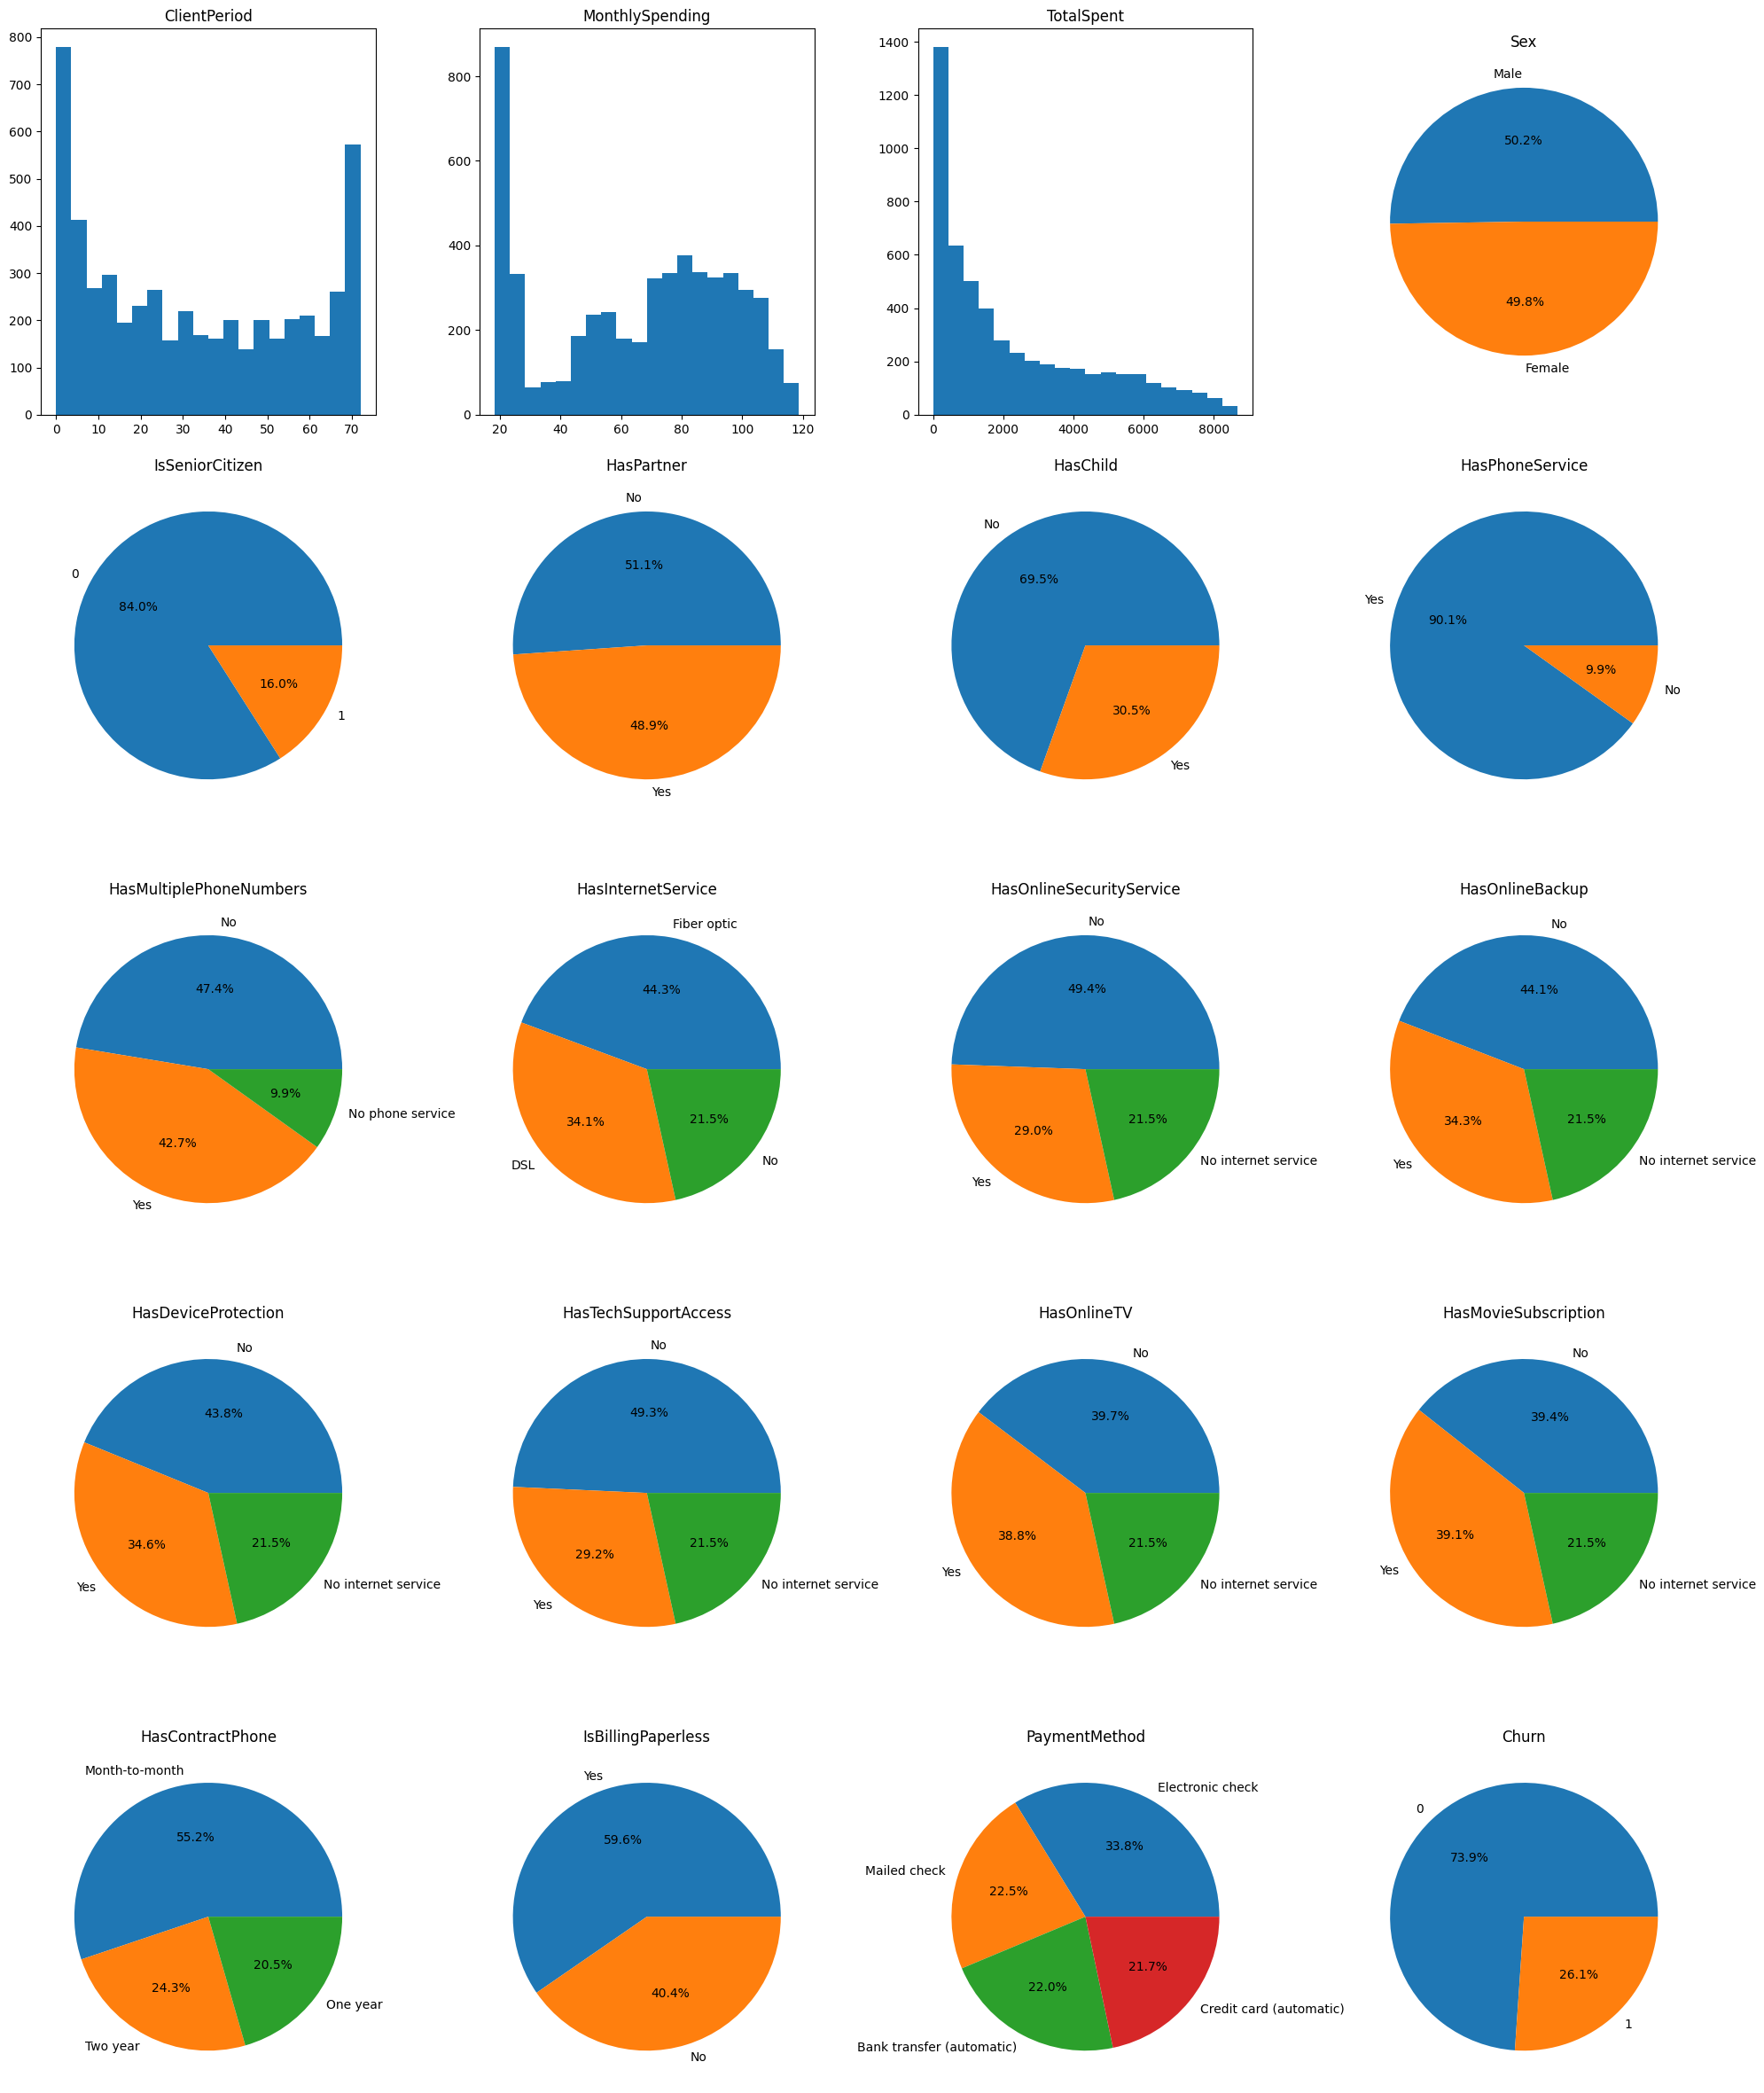

In [14]:
# Визулизируем распределения в колонках
n_bins, n_axes = 20, 0
height = 5
width = 4

fig, axes = plt.subplots(height, width, figsize=(20, 24), tight_layout=True)

for col in train.columns:
  i, j = n_axes // width, n_axes % width
  if col in num_cols:
    axes[i][j].hist(train[col], bins=n_bins)
  else:
    values = train[col].value_counts(normalize=True)
    sum_val = values.sum()
    values = values * 100
    axes[i][j].pie(values, labels=values.index, autopct='%1.1f%%')
  axes[i][j].set_title(col)
  n_axes += 1

Мы видим, что есть несбалансированные классы (например, HasPhoneService), но их доля в датасете мала, поэтому ничего с ними делать не будем

## Применение линейных моделей (3 балла)

### Задание

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а.

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC.

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора

### Решение

In [23]:
cls = make_pipeline(
    ColumnTransformer([('categorical', OneHotEncoder(sparse=False), cat_cols),
                       ('numerical', StandardScaler(), num_cols)]),
    LogisticRegression(max_iter=10000)
)

In [24]:
model_1 = GridSearchCV(estimator=cls,
                       param_grid={'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
                                   'logisticregression__C': [100, 10, 1, 0.1, 0.01, 0.001],
                                   'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']},
                       cv=5,
                       scoring='roc_auc',
                       verbose=0,
                       refit=True,
                       n_jobs=-1)

In [25]:
y = train[target_col]
X = train.drop(labels=target_col, axis=1)

In [26]:
# Обучение model_1 (~ 2 min)
model_1.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOn...
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.01,
                                                   0.001],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                         'logisticregression__solver': ['lbfgs', 'liblinear',
                                                        'newton-cg',
                                                        'newton-cholesky',
                                                        'sag', 'saga']},
             scoring='roc_auc')

### Итоговое качество

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [113]:
print('Лучшие параметры:', model_1.best_params_)
print('Итоговое качество:', round(model_1.best_score_, 4))

Лучшие параметры: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Итоговое качество: 0.8446


## Применение градиентного бустинга (2 балла)

### Задание

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

### Решение

Вначале попробуем Catboost с дефолтными параметрами

In [29]:
# Поделим датасет на train и valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                       train_size=0.8,
                                                       random_state=42)

In [34]:
# Обучение cb со стандартными параметрами (~ 18 s)
cb = CatBoostClassifier(cat_features=cat_cols)
cb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

In [35]:
roc_auc_score(y_valid, cb.predict_proba(X_valid)[:,1])

0.8442542573418717

**Вывод**: даже с дефолтными параметрами Catboost дает такое же качество, как LogisticRegression с наилучшими

In [149]:
# Попробуем найти наилучшие по значению ROC-AUC параметры (~ 25 min)
learning_rates = np.linspace(0.001, 0.1, 20)
depths = [4, 5, 6, 7]
n_estimators = [100, 500, 1000]
cb_best_roc_auc = 0

from itertools import product

param_combinations = list(product(depths, n_estimators, learning_rates))
n = len(param_combinations)
for i in range(n):
    cb_current = CatBoostClassifier(cat_features=cat_cols,
                                    depth=param_combinations[i][0],
                                    n_estimators=param_combinations[i][1],
                                    learning_rate=param_combinations[i][2],
                                    verbose=False,
                                    auto_class_weights='Balanced')

    cb_current.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    y_preds = cb_current.predict_proba(X_valid)[:,1]
    roc_auc = roc_auc_score(y_valid, y_preds)

    if cb_best_roc_auc < roc_auc:
        cb_best = cb_current
        cb_best_roc_auc = roc_auc

    print(f'Fitted {i+1}/{n} models')
    print(f'ROC AUC | current: {roc_auc}, best: {cb_best_roc_auc}')

Fitted 1/180 models
ROC AUC | current: 0.8202524710767772, best: 0.8202524710767772
Fitted 2/180 models
ROC AUC | current: 0.8225888874054499, best: 0.8225888874054499
Fitted 3/180 models
ROC AUC | current: 0.8337323272548143, best: 0.8337323272548143
Fitted 4/180 models
ROC AUC | current: 0.8327563267391914, best: 0.8337323272548143
Fitted 5/180 models
ROC AUC | current: 0.8372012724836911, best: 0.8372012724836911
Fitted 6/180 models
ROC AUC | current: 0.8381795748873226, best: 0.8381795748873226
Fitted 7/180 models
ROC AUC | current: 0.840608066736337, best: 0.840608066736337
Fitted 8/180 models
ROC AUC | current: 0.8414965955076354, best: 0.8414965955076354
Fitted 9/180 models
ROC AUC | current: 0.8417843315087035, best: 0.8417843315087035
Fitted 10/180 models
ROC AUC | current: 0.8438744458204619, best: 0.8438744458204619
Fitted 11/180 models
ROC AUC | current: 0.8433703323465906, best: 0.8438744458204619
Fitted 12/180 models
ROC AUC | current: 0.8438145967322399, best: 0.84387444

KeyboardInterrupt: ignored

### Итоговое качество

Выпишите, какое лучшее качество и с какими параметрами вам удалось получить

In [156]:
# Предыдущая ячейка с кодом после 25 минут работы выдает следующие параметры
cb_best = CatBoostClassifier(learning_rate=0.04268421052631579,
                             depth=4,
                             verbose=False,
                             auto_class_weights='Balanced',
                             n_estimators=500)
cb_best.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_cols, verbose=False)
final_roc = roc_auc_score(y_valid, cb_best.predict_proba(X_valid)[:,1])

In [157]:
print('Лучшие параметры:', cb_best.get_params())
print('Итоговое качество:', cb_best_roc_auc)

Лучшие параметры: {'learning_rate': 0.04268421052631579, 'depth': 4, 'verbose': False, 'auto_class_weights': 'Balanced', 'n_estimators': 500}
Итоговое качество: 0.8483055802369103


# Предсказания

In [159]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = cb_best.predict_proba(test)[:, 1]
submission.to_csv('./submission.csv', index=False)

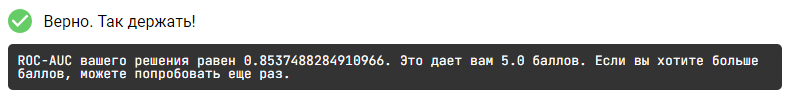